In [1]:
from fastai2.text.all import *

## Create databunch form LM

In [2]:
BPTT=10
BS=64

EN_FILE = Path('data/en-clean.txt')
EN_TEXT = EN_FILE.read()[1:].replace('\n', '').replace('  ', ' ')

In [3]:
len(EN_TEXT)

1039052

In [4]:
toks = tokenize1(EN_TEXT)

In [5]:
toks[:10]

(#10) ['xxbos','the','project','gutenberg','ebook','of','peter','pan',',','by']

In [6]:
vocab = make_vocab(Counter(toks), min_freq=3, max_vocab=4000)

len(vocab)

4008

In [7]:
vocab[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 '.',
 'the',
 'and',
 'to',
 'a']

In [8]:
# arbitrary way of splitting text into 'examples', would probably be better to split by chapters
# or something along these lines but shouldn't make much of a difference
txts = np.array_split(EN_TEXT.split(), 100)

In [9]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True)), splitter=RandomSplitter(seed=42))

In [10]:
dbunch_lm = dblock.databunch(txts, seq_len=BPTT, bs=BS) 

In [11]:
dbunch_lm.one_batch()[0].shape

torch.Size([64, 10])

## Train LM

In [12]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    AWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

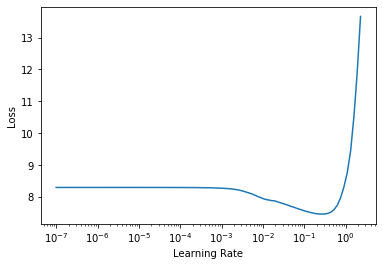

In [13]:
learn.lr_find()

In [14]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.947986,5.654605,0.096072,285.603760,00:11
1,5.553999,5.295511,0.138021,199.439560,00:10
2,5.264190,5.040707,0.169423,154.579208,00:10
3,5.065817,4.860946,0.194423,129.146347,00:10
4,4.933848,4.765520,0.202431,117.392159,00:10


In [15]:
learn.save('5epochs')

## Calculate loss given embeddings

In [16]:
learn = learn.load('5epochs')

In [17]:
def loss():
    preds, targs = learn.get_preds()
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [18]:
loss()

(8.219222068786621, 0.2029484510421753)

In [19]:
def loss():
    preds = []
    targs = []

    learn.model.eval()
    with torch.no_grad():
        for b in learn.dbunch.valid_dl:
            preds.append(learn.model(b[0])[0])
            targs.append(b[1])

    preds = torch.cat(preds, 1)
    targs = torch.cat(targs, 1)
    
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [20]:
loss()

(4.766682147979736, 0.20252913236618042)

Sylvain fixed the earlier issue I reported but now this doesn't look like. Opening another issue [issue](https://github.com/fastai/fastai2/issues/38).

In [21]:
learn.model[0].encoder.weight[:15].zero_();

In [22]:
loss()

(6.3147664070129395, 0.07172492891550064)

In [23]:
learn = learn.load('5epochs')

In [24]:
loss()

(4.767446994781494, 0.20266154408454895)

## Permute embeddings

In [25]:
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) )
        self.p = nn.Parameter( torch.eye(self.num_embeddings) )
        self.p.requires_grad = False
        
        self.reset_parameters()
        
    def forward(self, words):
        return F.embedding(words, self.p @ self.weight)
    
    def reset_parameters(self):
        pass
#         self.weight.data.normal_(0,1)
#         self.p.data = torch.eye(self.num_embeddings)
    

In [26]:
class pAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder = PermuteEmbedding(vocab_sz, emb_sz, padding_idx=pad_token)
#         self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.encoder_dp = self.encoder # chosing to train without embedding dropout (to reduce code complexity + not sure it makes a lot of sense for what we want to do anyhow) 
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

In [27]:
import fastai2
fastai2.text.models.core._model_meta[pAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [28]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

In [29]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.923940,5.599946,0.102083,270.411926,00:11
1,5.506311,5.272056,0.149067,194.816116,00:11
2,5.212064,5.024279,0.173307,152.060532,00:11
3,5.061054,4.851632,0.195508,127.949051,00:11
4,4.923724,4.755786,0.203125,116.254990,00:11
5,4.799407,4.670950,0.210026,106.799194,00:11
6,4.651469,4.580307,0.218620,97.544380,00:11
7,4.569399,4.522862,0.222418,92.098846,00:11
8,4.473880,4.482572,0.225152,88.461868,00:11
9,4.378886,4.452103,0.228646,85.807175,00:11


In [30]:
learn.save('pLSTM_10epochs')

In [31]:
learn.load('pLSTM_10epochs')

In [32]:
learn.predict('peter was', n_words=3, temperature=0.5)

'peter was to be his'

In [33]:
@patch_to(LMLearner)
@delegates(tokenize1)
def next_word_candidates(self, text, **kwargs):
    self.model.reset()
    tokens = tokenize1(text, **kwargs)
    tfm = self.dbunch.train_ds.numericalize
    idxs = tfm(tokens).to(self.dbunch.device)
    preds,_ = self.get_preds(dl=[(idxs[None],)])
    res = preds[0][-1]
    tokens = [tfm.vocab[i] for i in res.argsort(descending=True)]
    return tokens

In [34]:
learn.next_word_candidates('pete was')[:10]

['a', 'xxunk', 'the', 'not', 'his', 'an', 'in', 'to', 'no', 'that']

In [35]:
import warnings

In [36]:
@patch_to(LMLearner)
def optimize_permutation(self):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        self.freeze_to(4)
    learn.model[0].encoder.p.requires_grad = True
    
@patch_to(LMLearner)
def optimize_model(self):
    self.unfreeze()
    learn.model[0].encoder.p.requires_grad = False

In [37]:
learn.optimize_permutation()

In [38]:
learn.model[0].encoder.p.requires_grad

True

In [52]:
def aza_loss(input=None, target=None, scaling_factor=5/2000, debug=False):
    p = learn.model[0].encoder.p
    sums_to_one = (1-p.abs().sum(dim=0)).abs().sum() + (1-p.abs().sum(dim=1)).abs().sum()
#     extremize = (1-p.max(dim=0)[0]).abs().sum() + (1-p.max(dim=1)[0]).abs().sum() # + (p.min(dim=0)[0]).abs().max()#(10*(1-p.max()).abs()) + (10*p.min()).abs()
    the_model = CrossEntropyLossFlat()(input, target)
    if debug: return sums_to_one, the_model
    else:     return scaling_factor * sums_to_one + the_model

In [40]:
learn.loss_func = aza_loss

In [41]:
learn.model[0].encoder.p

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', requires_grad=True)

In [42]:
preds, targs = learn.get_preds()

In [53]:
aza_loss(preds, targs, debug=True)

(tensor(0., device='cuda:0', grad_fn=<AddBackward0>), tensor(4.4511))

In [54]:
nn.init.kaiming_normal_(learn.model[0].encoder.p)

Parameter containing:
tensor([[ 0.0522, -0.0522, -0.0098,  ...,  0.0150,  0.0074,  0.0354],
        [-0.0229, -0.0125, -0.0043,  ..., -0.0101,  0.0201, -0.0382],
        [ 0.0018,  0.0168, -0.0027,  ..., -0.0131,  0.0302, -0.0193],
        ...,
        [ 0.0068,  0.0160, -0.0507,  ..., -0.0035, -0.0147, -0.0063],
        [ 0.0309,  0.0065,  0.0119,  ...,  0.0188, -0.0115,  0.0369],
        [-0.0050,  0.0405, -0.0006,  ..., -0.0035,  0.0271, -0.0265]],
       device='cuda:0', requires_grad=True)

In [46]:
loss()

(6.6452202796936035, 0.046477753669023514)

In [56]:
aza_loss(preds, targs)

tensor(1415.5673, device='cuda:0', grad_fn=<AddBackward0>)

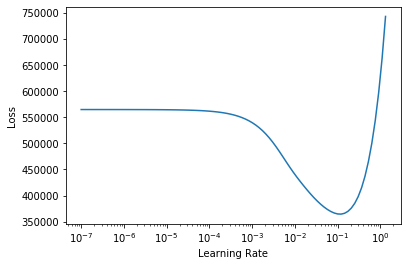

In [48]:
learn.lr_find()

In [57]:
learn.fit(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,284.624603,166.884308,0.175977,inf,00:11
1,11.160111,5.986102,0.175239,397.860748,00:11
2,5.613771,5.634641,0.191319,279.958313,00:11
3,5.561818,5.627398,0.195508,277.937866,00:11
4,5.480570,5.560521,0.199826,259.958160,00:11
5,5.399438,5.551347,0.200347,257.584351,00:11
6,5.434427,5.542597,0.203385,255.340210,00:11
7,5.417505,5.484816,0.205469,241.004501,00:11
8,5.420356,5.481819,0.206988,240.283417,00:11
9,5.359897,5.473883,0.206793,238.383972,00:11


In [58]:
learn.save('pLSTM_15epochs_permute_embeddings')

In [91]:
def hitInTopN(n=1, how_many=None, prints=True):
    data = learn.model[0].encoder.p.data.argsort(descending=True)[10:10+how_many, :n]
    hits = torch.any(data == torch.arange(10, how_many+10).reshape(-1,1).cuda(), -1)
    return hits.float().mean().item()

In [92]:
hitInTopN(1, 100), hitInTopN(5, 100)

(0.7699999809265137, 0.9799999594688416)

In [93]:
acc1 = [(x, hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, hitInTopN(10, x)) for x in range(50,1500,200)]

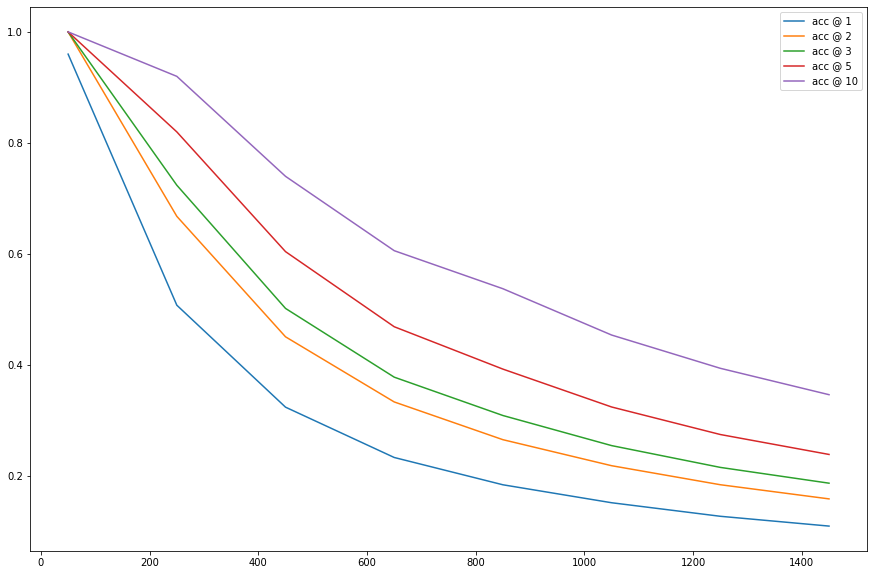

In [94]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [95]:
data = learn.model[0].encoder.p.data.argsort(descending=True)[:, :5]
print('actual word\t\tpredictions\n')
for i in range(60, 80):
    print(f'{learn.dbunch.vocab[i]}\t\t{[learn.dbunch.vocab[idx] for idx in data[i]]}')

actual word		predictions

would		['could', 'must', 'ca', 'would', 'should']
then		['then', 'said', 'though', 'however', 'presently']
we		['i', 'we', 'you', 'they', "d'you"]
my		['your', 'my', 'our', 'his', 'tinker']
what		['what', '?', 'how', 'that', 'why']
up		['up', 'down', 'out', 'forth', 'away']
from		['from', 'at', 'upon', 'under', 'into']
which		['which', 'who', 'that', 'whom', 'clair']
out		['out', 'rid', 'up', 'down', 'away']
me		['me', 'us', 'him', 'anything', 'you']
one		['one', 'copies', 'this', 'full', 'any']
if		['if', 'when', 'whom', 'unless', '”']
now		['now', 'oh', 'then', 'but', 'yes']
when		['when', 'till', 'if', 'which', ':']
them		['him', 'them', 'himself', 'us', 'me']
or		['and', 'or', 'which', 'of', '[']
could		['ca', 'could', 'must', 'can', 'shall']
been		['been', 'be', 'were', 'was', 'have']
are		['are', 'is', 'was', 'were', "'re"]
an		['an', 'a', 'neville', 'project', 'the']
